In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np

In [0]:
!unzip 'drive/My Drive/Cat_Dog_data.zip'

In [0]:
import torch 
from torchvision import transforms,datasets,models

In [0]:
train_dir = 'Cat_Dog_data/train'
train_transforms = transforms.Compose([
                            transforms.RandomRotation(30),
                            transforms.Resize(255),
                            transforms.CenterCrop(224),
                            transforms.ToTensor()
])

dataset = datasets.ImageFolder(train_dir , transform=train_transforms)
train_dataloader = torch.utils.data.DataLoader(dataset , shuffle = True , batch_size=32)

In [0]:
#test loader

test_transforms = transforms.Compose([transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                     transforms.ToTensor()])

test_dir = 'Cat_Dog_data/test'
test_dataset = datasets.ImageFolder(test_dir , transform = test_transforms)

test_dataloader= torch.utils.data.DataLoader(test_dataset , shuffle = True , batch_size=32)

In [0]:

def display(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

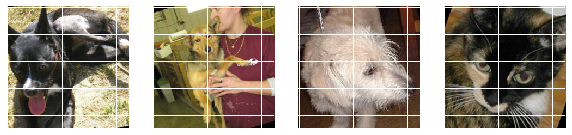

In [9]:
data_iter = iter(train_dataloader)
images , labels = next(data_iter)

fig , axes = plt.subplots(figsize = (10 , 4) , ncols = 4)
for i in range(4):
    ax = axes[i]
    display(images[i] , ax = ax , normalize = False)

In [10]:
model = models.densenet121(pretrained=True)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:01<00:00, 28324815.67it/s]


In [0]:
model

In [0]:
for param in model.parameters():
  param.requires_grad = False

In [0]:
from collections import OrderedDict

classifier = torch.nn.Sequential(OrderedDict([
    ('fc1' , torch.nn.Linear(1024 , 500)),
    ('relu' , torch.nn.ReLU()),
    ('fc3' , torch.nn.Linear(500 , 2)),
    ('output' , torch.nn.LogSoftmax(dim=1))
]))

model.classifier = classifier

In [0]:
model

In [0]:
train_on_gpu = torch.cuda.is_available()

In [0]:
if train_on_gpu:
  model.cuda()

In [0]:
criterion = torch.nn.NLLLoss()

optimizer = torch.optim.Adam(model.classifier.parameters() , lr = 0.001)

In [18]:
n_epochs = 15
train_loss = 0

for epoch in range(n_epochs + 1):
  model.train()
  
  for images,target in train_dataloader:
    if train_on_gpu:
      images , target = images.cuda() , target.cuda()
      
      optimizer.zero_grad()
      
      loss = criterion(model(images) , target)
      
      loss.backward()
      
      optimizer.step()
      train_loss += loss.item()*images.size(0)
      
  
  train_loss /= len(train_dataloader)
  
  print('Epoch----->{} \t Train_loss----->{}'.format(epoch , train_loss))
      
      
      
      
      
      
      
      

Epoch----->0 	 Train_loss----->3.5877280521883885
Epoch----->1 	 Train_loss----->2.8522213975120696
Epoch----->2 	 Train_loss----->2.317099575204426
Epoch----->3 	 Train_loss----->2.2559927368423742
Epoch----->4 	 Train_loss----->2.1675653712011567
Epoch----->5 	 Train_loss----->2.155763503538848
Epoch----->6 	 Train_loss----->1.8119953681074579
Epoch----->7 	 Train_loss----->2.0071589031241275
Epoch----->8 	 Train_loss----->2.1110963032719794
Epoch----->9 	 Train_loss----->1.8154598024230786
Epoch----->10 	 Train_loss----->1.8459284299429648
Epoch----->11 	 Train_loss----->1.8114436251864594
Epoch----->12 	 Train_loss----->1.7266012885245052
Epoch----->13 	 Train_loss----->1.7345433409379503
Epoch----->14 	 Train_loss----->1.6277471203181113
Epoch----->15 	 Train_loss----->1.5534158426109153


In [0]:
torch.save(model.state_dict() , 'cat_dog_classifier.pt')

In [22]:
test_loss = 0.0
accuracy = 0.0

model.eval()

for images,labels in test_dataloader:
  if train_on_gpu:
    images,labels = images.cuda() , labels.cuda()
    
    logps = model.forward(images)
    
    batch_loss = criterion(logps , labels)
    test_loss += batch_loss.item()
    
    ps = torch.exp(logps)    

    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test loss: {test_loss/len(test_dataloader):.3f}.. "
      f"Test accuracy: {accuracy/len(test_dataloader):.3f}")
    
    

Test loss: 0.033.. Test accuracy: 0.985
